In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#==============================================================
#                   Diffusion, FDM 2D
#==============================================================
Nx, Ny = 20, 20
Lx, Ly = 10, 10.
hx, hy = Lx/Nx, Ly/Ny
n = Nx*Ny
def getIndex(i, j, Nx, Ny):
    return j*Nx + i
# matrix with zero flux boundary conditions
def getA(n, Nx, Ny, arrK):
    A = np.zeros((n, n))            
    for i in range(Nx):
        for j in range(Ny):
            I = getIndex(i, j, Nx, Ny)
            diagval = 0.0
            # j-1
            if j!=0:
                J = getIndex(i, j-1, Nx, Ny)
                val = 2.0/(1./arrK[J] + 1./arrK[I])/hy**2
                A[I, J] = -val
                diagval += val
            # j+1
            if j!=(Ny-1):
                J = getIndex(i, j+1, Nx, Ny)
                val = 2.0/(1./arrK[J] + 1./arrK[I])/hy**2
                A[I, J] = -val
                diagval += val
            # i-1
            if i!=0:
                J = getIndex(i-1, j, Nx, Ny)
                val = 2.0/(1./arrK[J] + 1./arrK[I])/hx**2
                A[I, J] = -val
                diagval += val
            # i+1
            if i!=(Ny-1):
                J = getIndex(i+1, j, Nx, Ny)
                val = 2.0/(1./arrK[J] + 1./arrK[I])/hx**2
                A[I, J] = -val
                diagval += val
            A[I, I] = diagval
    # print(A)
    return A
# for plot
mx = np.linspace(0, Lx, Nx)
my = np.linspace(0, Ly, Ny)
mX, mY = np.meshgrid(mx, my)
# def plotit(x1, x2, nm1, nm2):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
#     im1 = ax1.pcolor(mX, mY, x1.reshape(Nx, Ny))
#     ax1.set_title(nm1)
#     plt.colorbar(im1, ax=ax1)
#     im2 = ax2.pcolor(mX, mY, x2.reshape(Nx, Ny))
#     ax2.set_title(nm2)
#     plt.colorbar(im2, ax=ax2)
#     plt.tight_layout()
#     plt.show()
def plotit(xs, nms, mx, my, Nx, Ny):
    N = len(nms)
    fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(4*N+1, 4))  # Create subplots
    if N == 1:
        axes = [axes]  # Ensure it's iterable when N=1
    for i, ax in enumerate(axes):
        im = ax.pcolor(mX, mY, xs[i].reshape(Nx, Ny))
        ax.set_title(nms[i])
        plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

0.2 24999.999999999996


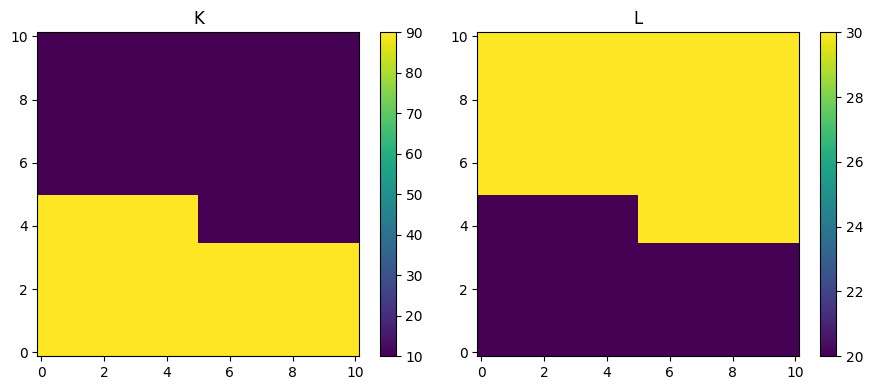

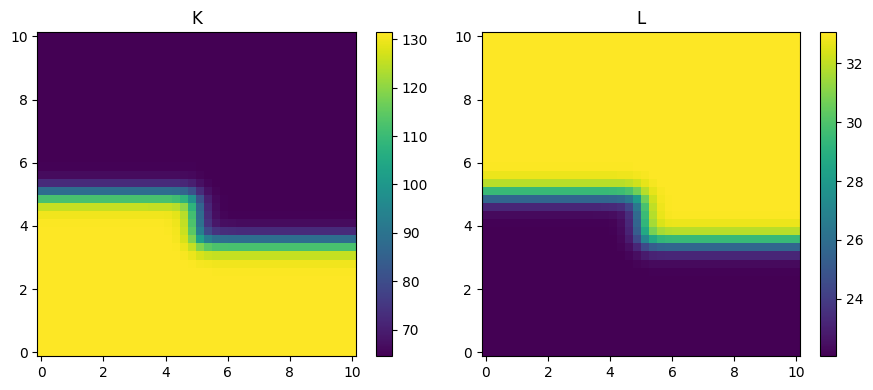

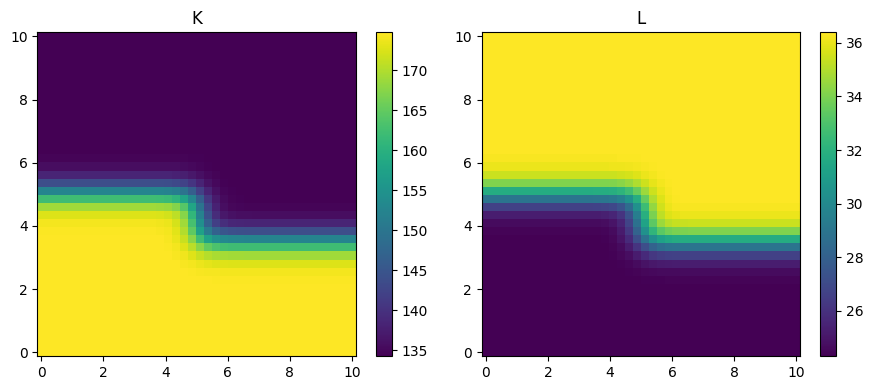

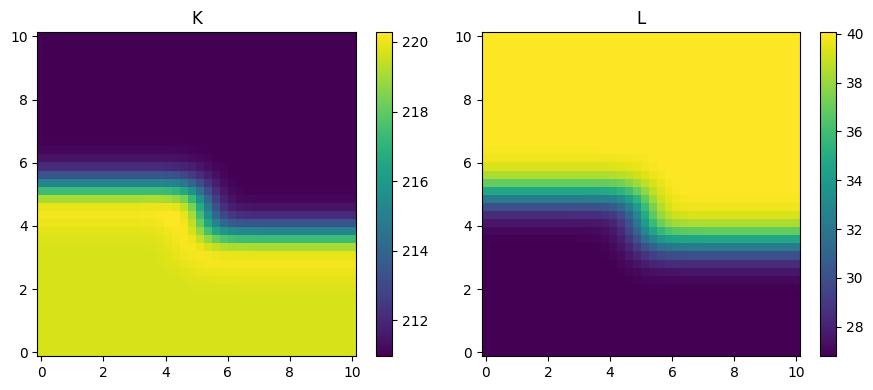

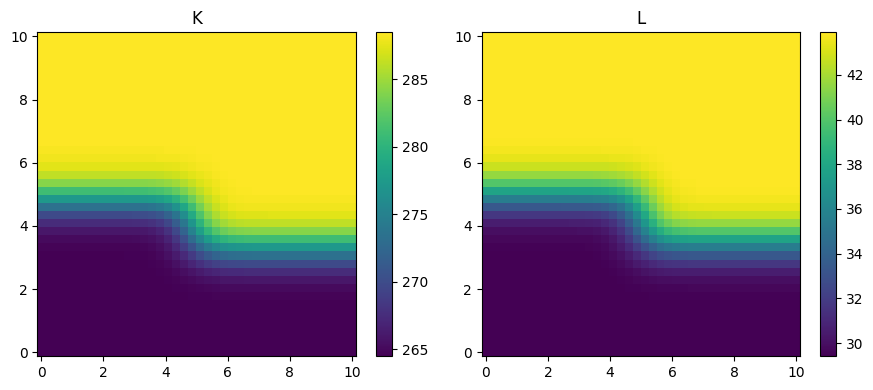

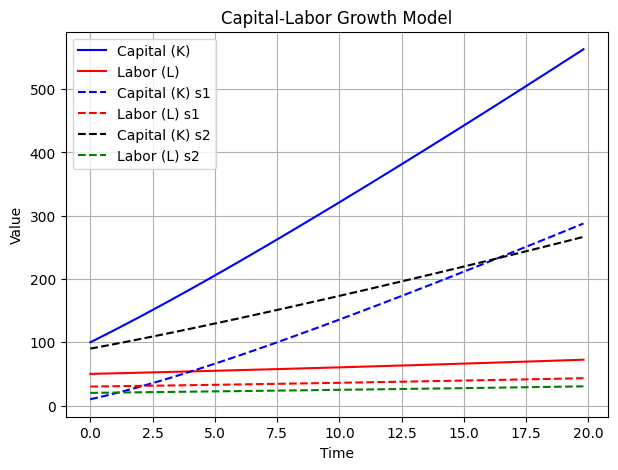

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Solow-Swan Model Equations
def capital_labor_model(t, y, s, delta, alpha, g):
    K, L = y
    Y = K**alpha * L**(1-alpha)  # Cobb-Douglas production function
    dK_dt = s * Y - delta * K    # Capital accumulation
    dL_dt = g * L *(1 - L/C)     # Labor growth
    return [dK_dt, dL_dt]

# Parameters
s = 0.4      # Savings rate
delta = 0.05  # Depreciation rate
alpha = 0.3   # Output elasticity of capital
g, C = 0.02, 1000  # Labor growth rate

# Initial conditions: Capital (K0) and Labor (L0)
y0 = [100, 50]

Tmax = 20#500
Nt = 100
dt = Tmax/Nt

Nx, Ny = 40, 40
#Nx, Ny = 60, 60
Lx, Ly = 10, 10.
hx, hy = Lx/Nx, Ly/Ny
n = Nx*Ny
mx = np.linspace(0, Lx, Nx)
my = np.linspace(0, Ly, Ny)
mX, mY = np.meshgrid(mx, my)

# ----- simple solve ODE -----
y, t = np.zeros((2, Nt)), np.zeros(Nt)
y[:, 0] = y0
for i in range(1, Nt):
    fy = capital_labor_model(t, y[:, i-1], s, delta, alpha, g)
    y[:, i] = y[:, i-1] + dt*np.array(fy)
    t[i] = dt*i

# ----- solve with diffusion, PDE -----
vc = 1.0e-5
# vc = 1.0e-3
print(dt, hx/vc)
dx = np.zeros(n)
def getUpwindConvIJ(x1, x2, I, J, mh):
    vel = -(x1[I] - x1[J])/mh # flux
    upx = x2[I]
    if vel < 0:  
        upx = x2[J]
    return upx*vel 
def getConv(vc, x1, x2):
    dx.fill(0.0)
    for j in range(Ny):
        for i in range(Nx):
            I = getIndex(i, j, Nx, Ny)
            val = 0.0
            # j-1
            if j!=0:
                J = getIndex(i, j-1, Nx, Ny); mh = hy
                val += vc*getUpwindConvIJ(x1, x2, I, J, mh)
            # j+1
            if j!=(Ny-1):
                J = getIndex(i, j+1, Nx, Ny); mh = hy
                val += vc*getUpwindConvIJ(x1, x2, I, J, mh)
            # i-1
            if i!=0:
                J = getIndex(i-1, j, Nx, Ny); mh = hx
                val += vc*getUpwindConvIJ(x1, x2, I, J, mh)
            # i+1
            if i!=(Ny-1):
                J = getIndex(i+1, j, Nx, Ny); mh = hx
                val += vc*getUpwindConvIJ(x1, x2, I, J, mh)
            dx[I] =  -val  
    return dx
def getav(x):
    av1, av2 = 0,0 
    n1, n2 = 0,0
    for j in range(Ny):
        for i in range(Nx):
            I = getIndex(i, j, Nx, Ny)
            if (j >= Ny/2 and i < Nx/2) or (j >= Ny/3 and i >= Nx/2):
                av1 += x[I]; n1+=1
            else:
                av2 += x[I]; n2+=1
    return av1/n1, av2/n2
x1, x2 = np.zeros(n), np.zeros(n)
b1, b2 = np.zeros(n), np.zeros(n)
# heterogeneous coeff
# d1, d2 = 3*1.0e-2, 1./2*1.0e-2
# d1, d2 = 2*1.0e-2, 2*1.0e-2
d1, d2 = 1.0e-2, 1.0e-2
k1, k2 = np.zeros(n), np.zeros(n)
for j in range(Ny):
    for i in range(Nx):
        I = getIndex(i, j, Nx, Ny)
        x1[I], x2[I] = y0[0]*0.9, y0[1]*0.4
        k1[I], k2[I] = d1, d2
        # if j < Ny/4:
        #     k1[I] = d1/10  
        #     k2[I] = d2/10        
        if (j >= Ny/2 and i < Nx/2) or (j >= Ny/3 and i >= Nx/2):
            x1[I], x2[I] = y0[0]*0.1, y0[1]*0.6
plotit([x1, x2], ['K', 'L'], mx, my, Nx, Ny)
# implicit diffusion - explicit reaction
# M (y - yp)/dt = Ay + f(yp) 
# M (y - yp) = dt*A y + dt*f(y)
# add time S = M + dt*A
M = np.identity(n) # M = I for FDM
S1 = M + dt*getA(n, Nx, Ny, k1)
S2 = M + dt*getA(n, Nx, Ny, k2)
# solve
yds1, yds2, t = np.zeros((2, Nt)),  np.zeros((2, Nt)), np.zeros(Nt)
yds1[0, 0] = getav(x1)[0]# average over subdomains
yds1[1, 0] = getav(x2)[0]# average over subdomains
yds2[0, 0] = getav(x1)[1]# average over subdomains
yds2[1, 0] = getav(x2)[1]# average over subdomains
for ti in range(1, Nt):
    for I in range(n):
        fy = capital_labor_model(t, [x1[I], x2[I]], s, delta, alpha, g)
        b1[I] = x1[I] + dt * fy[0]
        b2[I] = x2[I] + dt * fy[1]
    x1 = np.linalg.solve(S1, b1)
    dd = getConv(vc, x1, x2)
    b2 += dt*dd
    # print(ti, min(dd), max(dd))
    x2 = np.linalg.solve(S2, b2)
    yds1[0, ti] = getav(x1)[0]# average over subdomains
    yds1[1, ti] = getav(x2)[0]# average over subdomains
    yds2[0, ti] = getav(x1)[1]# average over subdomains
    yds2[1, ti] = getav(x2)[1]# average over subdomains
    t[ti] = dt*ti
    if ti%int(Nt/4) == 0 or ti == Nt-1:    
        plotit([x1, x2], ['K', 'L'], mx, my, Nx, Ny)
        
# Plot results
plt.figure(figsize=(7, 5))
plt.plot(t, y[0, :], label="Capital (K)", color='b')
plt.plot(t, y[1, :], label="Labor (L)", color='r')
plt.plot(t, yds1[0, :], label="Capital (K) s1", color='b', ls='dashed')
plt.plot(t, yds1[1, :], label="Labor (L) s1", color='r', ls='dashed')
plt.plot(t, yds2[0, :], label="Capital (K) s2", color='black', ls='dashed')
plt.plot(t, yds2[1, :], label="Labor (L) s2", color='g', ls='dashed')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Capital-Labor Growth Model")
plt.grid()
# plt.savefig('a2.png')
plt.show()